Cut_in_series get data

Filter:

isCutIn = stdDevLat > 0.5                
          & minDistLat < 2             
          & maxDiffObj < 0.5            
          & ~isCutOut                   
          & max(abs(...)) > 2.5         
          & maxLateralMovement > 2.5;   


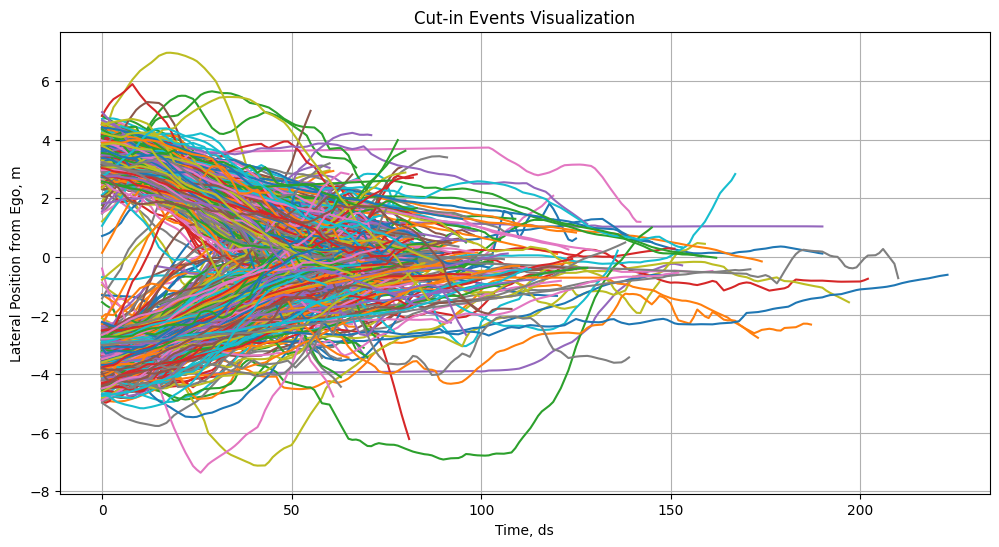

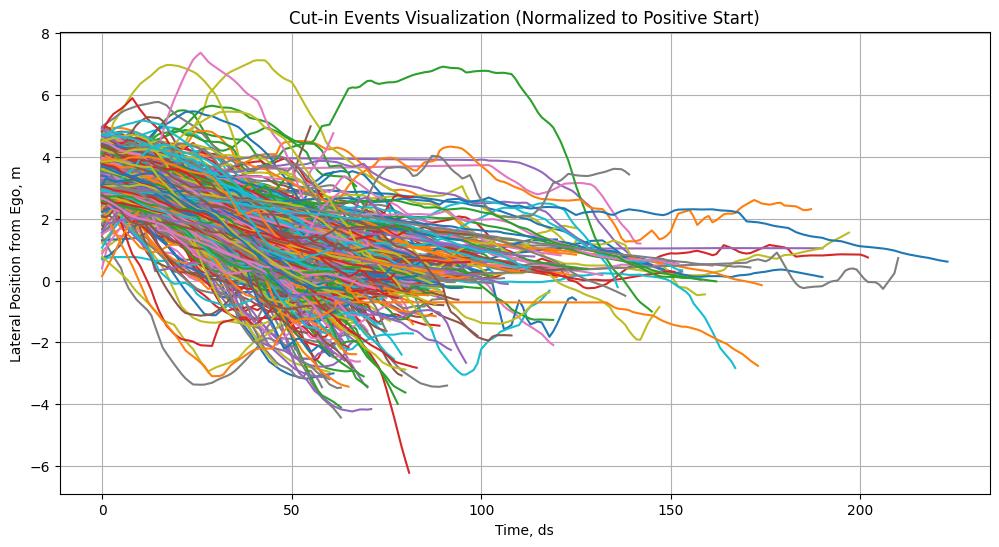

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = 'cutin_results_1111.csv'
data = pd.read_csv(file_path)  
CUTIN_objV2PosYM = data['objV2PosYM'].to_numpy()  

data['label_start_time'] = data['label_start_time'].astype(float)
data['objV2PosYM'] = data['objV2PosYM'].astype(float)
data['speedKmPerH'] = data['speedKmPerH'].astype(float)
unique_cutins = data['cutin_id'].unique()

plt.figure(figsize=(12, 6))

for cutin_id in unique_cutins:
    cutin_data = data[data['cutin_id'] == cutin_id]
    time_zeroed = cutin_data['tRelMs'] - cutin_data['tRelMs'].iloc[0]
    plt.plot(time_zeroed/100, cutin_data['objV2PosYM'])

plt.title('Cut-in Events Visualization')
plt.xlabel('Time, ds')
plt.ylabel('Lateral Position from Ego, m')
plt.grid(True)

plt.show()

plt.figure(figsize=(12, 6))

for cutin_id in unique_cutins:
    cutin_data = data[data['cutin_id'] == cutin_id]
    time_zeroed = (cutin_data['tRelMs'] - cutin_data['tRelMs'].iloc[0]) / 100  # 单位: ds
    y = cutin_data['objV2PosYM'].to_numpy()

    if y[0] < 0:
        y = -y

    plt.plot(time_zeroed, y)

plt.title('Cut-in Events Visualization (Normalized to Positive Start)')
plt.xlabel('Time, ds')
plt.ylabel('Lateral Position from Ego, m')
plt.grid(True)
plt.show()

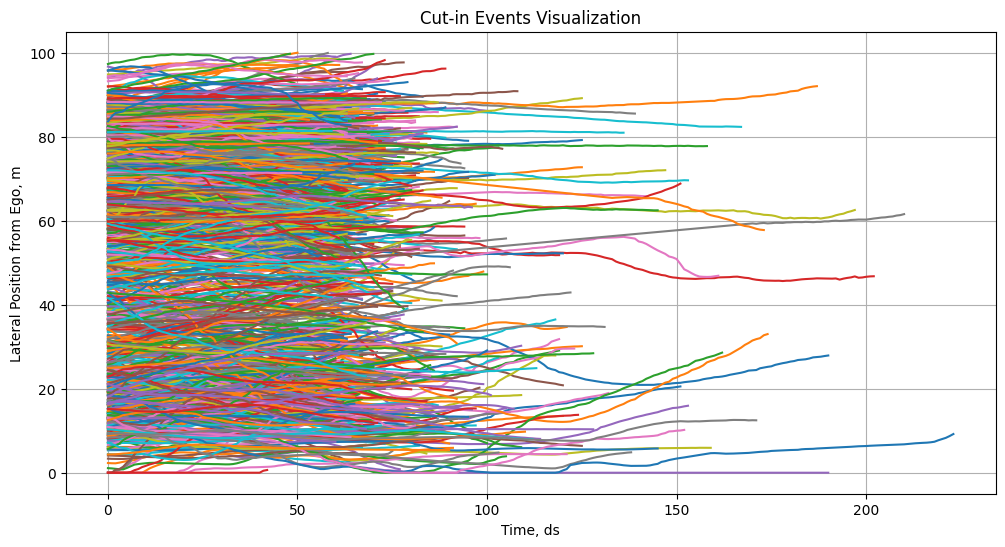

In [4]:
plt.figure(figsize=(12, 6))

for cutin_id in unique_cutins:
    cutin_data = data[data['cutin_id'] == cutin_id]
    time_zeroed = cutin_data['tRelMs'] - cutin_data['tRelMs'].iloc[0]
    plt.plot(time_zeroed/100, cutin_data['speedKmPerH'])

plt.title('Cut-in Events Visualization')
plt.xlabel('Time, ds')
plt.ylabel('Lateral Position from Ego, m')
plt.grid(True)

plt.show()

Data classificaton

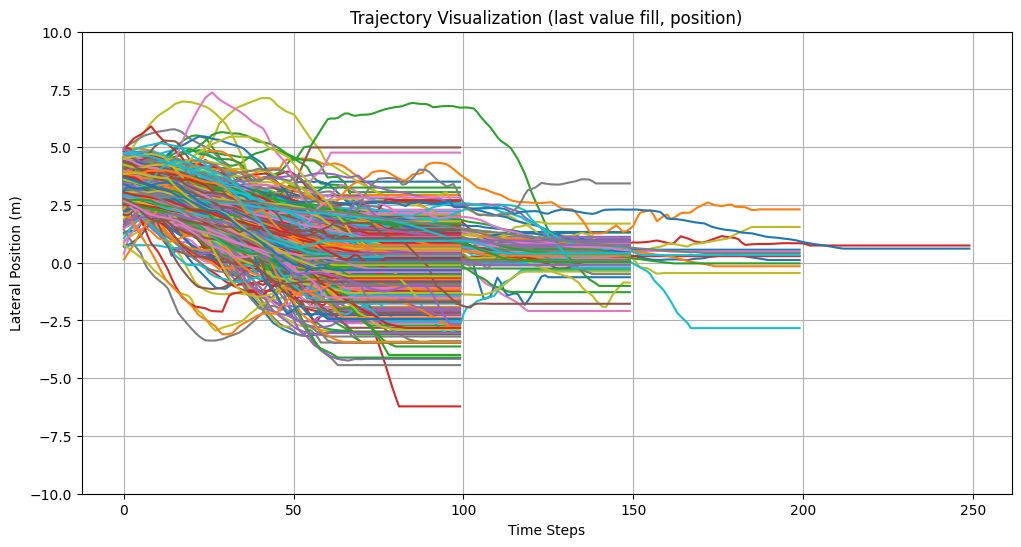

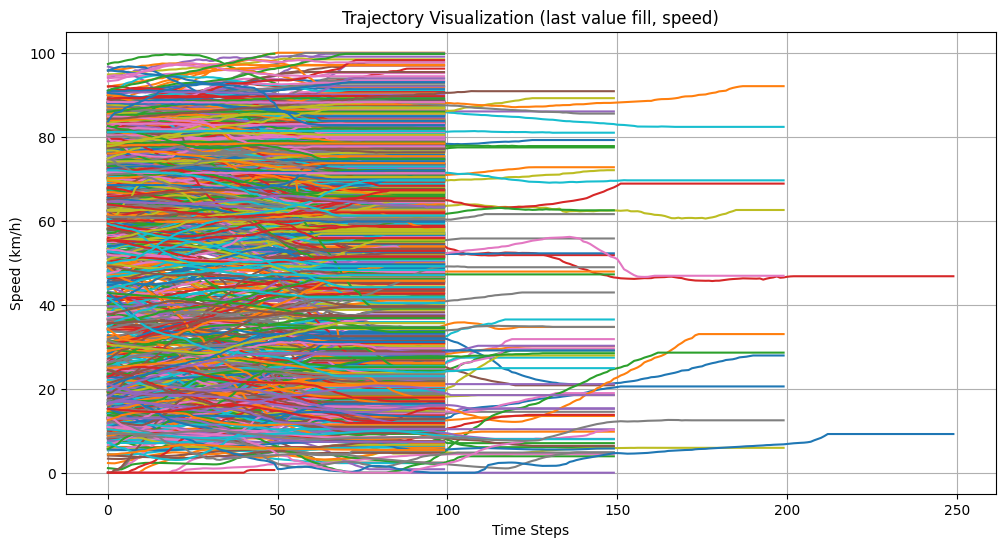

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform, ReversePermutation


data = pd.read_csv('cutin_results_1111.csv')
data['cutin_id'] = data['cutin_id'].astype(str)
data['objV2PosYM'] = data['objV2PosYM'].astype(float)
data['speedKmPerH'] = data['speedKmPerH'].astype(float)
data['tRelMs'] = data['tRelMs'].astype(float)

trajectory_list = []
trajectory_dict = {}

for cutin_id in data['cutin_id'].unique():
    group = data[data['cutin_id'] == cutin_id].sort_values(by='tRelMs')
    y = group['objV2PosYM'].to_numpy()
    speed = group['speedKmPerH'].to_numpy()

    if y[0] < 0:
        y = -y  # normalize direction

    length = len(y)
    target_length = ((length // 50) + 1) * 50

    pos_filled = np.full(target_length, y[-1])
    speed_filled = np.full(target_length, speed[-1])
    pos_filled[:length] = y
    speed_filled[:length] = speed

    trajectory = np.stack([pos_filled, speed_filled], axis=-1)  # (time_steps, 2)
    trajectory_list.append(trajectory)

    if target_length not in trajectory_dict:
        trajectory_dict[target_length] = []
    trajectory_dict[target_length].append(trajectory)

plt.figure(figsize=(12, 6))
for i, trajectory in enumerate(trajectory_list):
    plt.plot(trajectory[:, 0], label=f'Traj {i+1} Pos')
plt.title('Trajectory Visualization (last value fill, position)')
plt.xlabel('Time Steps')
plt.ylabel('Lateral Position (m)')
plt.grid(True)
plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(12, 6))
for i, trajectory in enumerate(trajectory_list):
    plt.plot(trajectory[:, 1], label=f'Traj {i+1} Speed')
plt.title('Trajectory Visualization (last value fill, speed)')
plt.xlabel('Time Steps')
plt.ylabel('Speed (km/h)')
plt.grid(True)
plt.show()


NF training

In [6]:
models = {}

for length, trajectories in trajectory_dict.items():
    trajectory_array = np.stack(trajectories)  # [num_samples, time_steps, 2]
    num_samples, time_steps, num_channels = trajectory_array.shape
    trajectory_array = trajectory_array.reshape(num_samples, time_steps * num_channels)

    if len(trajectories) < 20:
        continue

    print(f"\nTraining model for trajectory length: {length}, Number of samples: {len(trajectories)}")
    
    pca_full = PCA()
    pca_full.fit(trajectory_array)
    cum_var = np.cumsum(pca_full.explained_variance_ratio_)
    target_dim = np.argmax(cum_var >= 0.95) + 1
    n_components = target_dim
    pca = PCA(n_components=10)
    trajectory_latent = pca.fit_transform(trajectory_array)

    latent_dim = trajectory_latent.shape[1]
    base_dist = StandardNormal([latent_dim])

    transforms = []
    for _ in range(2):
        transforms.append(ReversePermutation(features=latent_dim))
        transforms.append(MaskedAffineAutoregressiveTransform(features=latent_dim, hidden_features=128))
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)

    x_train = torch.tensor(trajectory_latent, dtype=torch.float32)
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

    for epoch in range(1000):
        optimizer.zero_grad()
        loss = -flow.log_prob(x_train).mean()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"[Pretrain] Epoch {epoch}, NLL: {loss.item():.4f}")

    models[length] = (flow, pca)




Training model for trajectory length: 100, Number of samples: 1011
[Pretrain] Epoch 0, NLL: 61170.9805
[Pretrain] Epoch 200, NLL: 34.6181
[Pretrain] Epoch 400, NLL: 33.2637
[Pretrain] Epoch 600, NLL: 32.6198
[Pretrain] Epoch 800, NLL: 32.1581

Training model for trajectory length: 150, Number of samples: 56
[Pretrain] Epoch 0, NLL: 202449.3906
[Pretrain] Epoch 200, NLL: 43.8168
[Pretrain] Epoch 400, NLL: 38.0415
[Pretrain] Epoch 600, NLL: 35.9146
[Pretrain] Epoch 800, NLL: 33.9586

Training model for trajectory length: 50, Number of samples: 30
[Pretrain] Epoch 0, NLL: 12249.8496
[Pretrain] Epoch 200, NLL: 22.3773
[Pretrain] Epoch 400, NLL: 15.8740
[Pretrain] Epoch 600, NLL: 12.6122
[Pretrain] Epoch 800, NLL: 9.7918


Sampling

In [7]:
total_samples = sum(len(trajectories) for trajectories in trajectory_dict.values())
length_ratios = {length: len(trajectories) for length, trajectories in trajectory_dict.items()}
n_sample = 20
sampled_trajectories = []

for length, count in length_ratios.items():
    ratio = int((count / total_samples) * n_sample)
    if length in models:
        flow, pca = models[length]
        
        for _ in range(ratio):
            samples = flow.sample(1).detach().numpy()  # (1, latent_dim)

            new_trajectory = pca.inverse_transform(samples)  # (1, time_steps * num_channels)
            time_steps = length
            num_channels = 2
            new_trajectory = new_trajectory.reshape(time_steps, num_channels)

            sampled_trajectories.append(new_trajectory)




number of filtered sample: 14 / 19


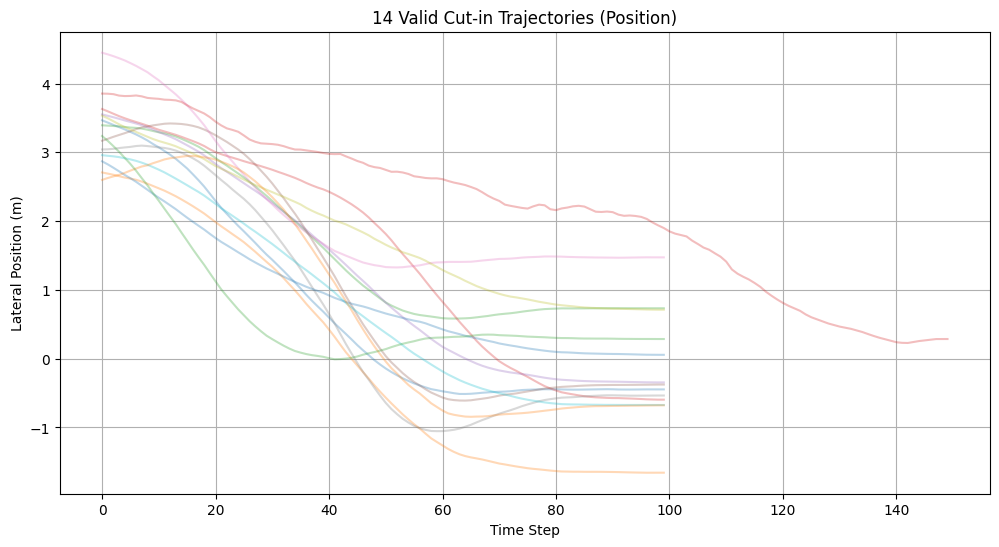

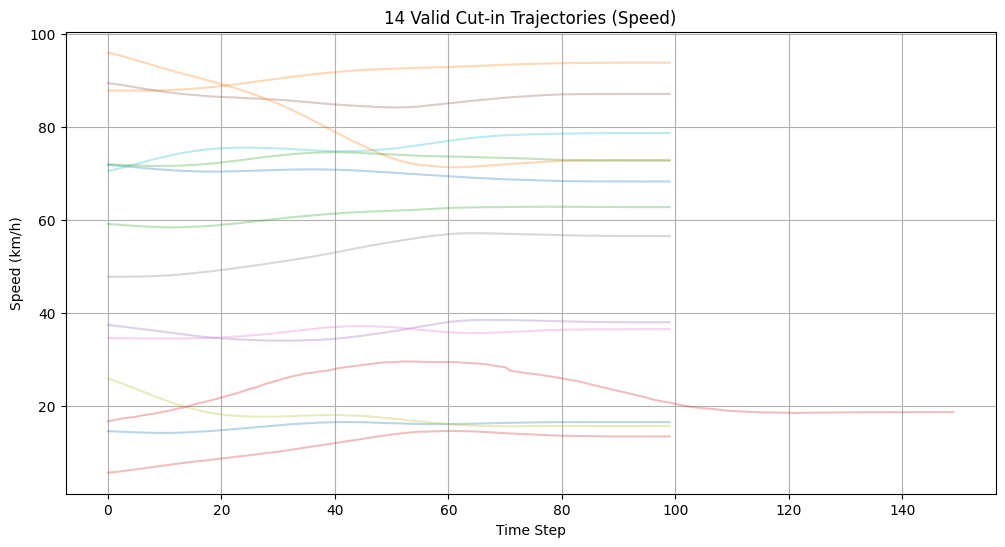

In [8]:
def is_cutin_trajectory(traj):
    pos_traj = np.array(traj[:, 0])  
    speed_traj = np.array(traj[:, 1])

    pos_traj = np.array(pos_traj)
    min_dist_lat = np.min(np.abs(pos_traj))
    std_dev_lat = np.std(pos_traj)

    n = int(np.ceil(len(pos_traj) / 2))
    first_half = pos_traj[:n]
    second_half = pos_traj[n:]

    diff_y = np.diff(pos_traj)
    max_diff = np.max(np.abs(diff_y))

    max_lateral_movement = np.max(np.abs(pos_traj)) - np.min(np.abs(pos_traj))
    mean_first = np.mean(np.abs(first_half))
    mean_second = np.mean(np.abs(second_half))

    is_cut_out = mean_first < mean_second

    pos_condition = (
        std_dev_lat > 0.5 and
        min_dist_lat < 2 and
        max_diff < 0.5 and
        not is_cut_out and
        np.max(np.abs(pos_traj)) > 2.5 and
        max_lateral_movement > 2.5
    )

    speed_condition = (speed_traj > 0) & (speed_traj < 100)
    is_cutin = pos_condition and speed_condition.all()
    return is_cutin


filtered_samples = [
    traj for traj in sampled_trajectories
    if is_cutin_trajectory(traj)
]

num_valid = len(filtered_samples)
print(f"number of filtered sample: {num_valid} / {len(sampled_trajectories)}")


plt.figure(figsize=(12, 6))
for traj in filtered_samples:
    plt.plot(traj[:, 0], alpha=0.3)
plt.title(f"{num_valid} Valid Cut-in Trajectories (Position)")
plt.xlabel("Time Step")
plt.ylabel("Lateral Position (m)")

plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for traj in filtered_samples:
    plt.plot(traj[:, 1], alpha=0.3)
plt.title(f"{num_valid} Valid Cut-in Trajectories (Speed)")
plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.grid(True)
plt.show()